In [1]:
import pandas as pd 
import gensim
import numpy as np
from numpy import zeros
from numpy import asarray

import os
import re
import csv
import codecs
import sys
from csv import DictReader

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras import callbacks, optimizers, initializers, regularizers, constraints
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, Flatten, concatenate, dot
from keras.layers.merge import concatenate
from tensorflow.keras.layers import BatchNormalization, Layer, InputSpec
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from IPython.display import SVG

from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    print("Score",score)
    best_score, _ = score_submission(actual,actual)
    # print("best_Score",best_score)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

Score 6.75
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |     0     |     1     |     0     |
-------------------------------------------------------------
| disagree  |     0     |     2     |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     2     |
-------------------------------------------------------------
Score: 6.75 out of 7.5	(90.0%)


In [ ]:
#To get vec W2V model

#!git clone https://github.com/mmihaltz/word2vec-GoogleNews-vectors.git

Cloning into 'word2vec-GoogleNews-vectors'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.


In [3]:
#GloVe Location
GloVe_path = '/content/drive/MyDrive/FNC/glove.6B.300d.txt' #Glove

In [4]:
#Parameters
MAX_SENT_LEN = 150 #For headline and body
MAX_VOCAB_SIZE = 40000 #Use the top 40000 by frequency, because there are too many unique words
EMBEDDING_DIM = 300 #for W2V
BATCH_SIZE = 128
N_EPOCHS = 20 #can be seen from function that it gets overtrained

In [5]:
#Dataset class adapted from FNC Baseline

class DataSet():
    def __init__(self, name="train", path="/content/drive/MyDrive/FNC/data"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows

In [6]:
#Generate Feautres class adapted from FNC Baseline

def generate_features(stances,dataset):
    h, b, y = [],[],[]
    LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
    
    for stance in stances:

        # print(stance['Stance'])
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
   
    return(h,b,y)

In [7]:
#Combine article bodies with headlines for training

dataset = DataSet()

h, b, y= generate_features(dataset.stances,dataset)

combined_list = [list(x) for x in zip(h, b,y)]

combined_train=pd.DataFrame(combined_list,columns = ["Headline","articleBody","Stances"])

combined_train.to_csv("/content/drive/MyDrive/FNC/data/combined_list_1.csv")

Reading dataset
Total stances: 49972
Total bodies: 1683


In [8]:
combined_train.head()

,Headline,articleBody,Stances
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,3
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,0
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,3
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,3
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",1


In [9]:
#Combine article bodies with headlines for final testing using competition data

comp_dataset = DataSet("competition_test")

h_test,b_test,y_test= generate_features(comp.stances,comp_dataset)

combined_list_test = [list(x_test) for x_test in zip(h_test, b_test, y_test)]

combine_df_test=pd.DataFrame(combined_list_test,columns = ["Headline","articleBody","Stances"])

combine_df_test.to_csv("/content/drive/MyDrive/FNC/data/combined_list_test.csv")

Reading dataset
Total stances: 25413
Total bodies: 904


In [10]:
combine_df_test.head()

,Headline,articleBody,Stances
0,Ferguson riots: Pregnant woman loses eye after...,A RESPECTED senior French police officer inves...,3
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,Dave Morin's social networking company Path is...,3
2,A Russian Guy Says His Justin Bieber Ringtone ...,A bereaved Afghan mother took revenge on the T...,3
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",Hewlett-Packard is officially splitting in two...,3
4,Argentina's President Adopts Boy to End Werewo...,An airline passenger headed to Dallas was remo...,3


In [11]:
#Data preprocessing, removing stopwords

stop_words = set(stopwords.words('english')) 

def cleanser(text):
    cleanString = text.lower()
    cleanString = re.sub('<br\s?\/>|<br>', "", cleanString)
    cleanString = cleanString.replace('\n','')
    cleanString = re.sub(r'\([^)]*\)', '', cleanString)
    cleanString = re.sub('"','', cleanString)

    cleanString = re.sub(r"'s\b","",cleanString)
    cleanString = re.sub("[^a-zA-Z]", " ", cleanString) 

    tokens = [w for w in cleanString.split() if not w in stop_words]
    return ( " ".join(tokens)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
#TF-IDF creation

train_head = [cleanser(head) for head in combined_train['Headline']]
train_body = [cleanser(body) for body in combined_train['articleBody']]
test_head = [cleanser(head) for head in combine_df_test['Headline']]
test_body = [cleanser(body) for body in combine_df_test['articleBody']]

vectorizer = TfidfVectorizer(max_features = 150)

X_train_head_tfidf = vectorizer.fit_transform(train_head).toarray()
X_train_body_tfidf = vectorizer.fit_transform(train_body).toarray()

X_test_head_tfidf= vectorizer.transform(test_head).toarray()
X_test_body_tfidf = vectorizer.transform(test_body).toarray()

tf.compat.v1.disable_eager_execution()

(49972, 150)


In [13]:
# Run cleanser funcion on head and body

word_seq_head_train = [text_to_word_sequence(cleanser(head)) for head in combined_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(cleanser(body)) for body in combined_train['articleBody']]

word_seq_head_test = [text_to_word_sequence(cleanser(head)) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(cleanser(body)) for body in combine_df_test['articleBody']]

In [14]:
#Check for available GPU to run model on

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
#Populate word_seq

#for training
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])

#for testing
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [16]:
#Final number of words in vocabulary
#only including unique words

filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list) #Use max vocab size parameter
tokenizer.fit_on_texts([seq for seq in word_seq])

print("Vocab Size ", len(tokenizer.word_index))

Number of words in vocabulary: 29977


In [17]:
#Shorten and convert words to sequences and pad
#LSTM


X_train_head = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_head_train])
X_train_head = pad_sequences(X_train_head, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_train_body = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_bodies_train])
X_train_body = pad_sequences(X_train_body, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y_train = combined_train['Stances']


X_test_head = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_head_test])
X_test_head = pad_sequences(X_test_head, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_test_body = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_bodies_test])
X_test_body = pad_sequences(X_test_body, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y_test = combine_df_test['Stances']


y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [18]:
#Word 2 Vec Embedding
#Create embedding matrix

def embed_matrix(model,word_index,EMBEDDING_DIM):

  embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) #initialize matrix

  for word, i in word_index.items(): #for each word, if there is no pre-trained embedding then the embedding_matrix[i] is populated 
      try:
          embeddings_vector = model.wv.get_vector(word)
      except KeyError:
          embeddings_vector = None

      if embeddings_vector is not None:
          embeddings_matrix[i] = embeddings_vector

  return embeddings_matrix

In [ ]:
#import gzip
#import shutil
#with gzip.open('/content/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in:
#    with open('/content/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

In [ ]:
#!mkdir -p /content/drive/MyDrive/FNC/.kaggle/
#!echo '{"username":"natgillin","key":"54ae95ab760b52c3307ed4645c6c9b5d"}' > /root/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json
#!kaggle datasets download alvations/vegetables-google-word2vec

100% 1.65G/1.66G [00:15<00:00, 146MB/s]
100% 1.66G/1.66G [00:15<00:00, 118MB/s]


In [22]:
#!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=40b29d8229f96ab28beeecede3d76cbb617f4ed7507e8ca763254487948e8b7a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [23]:
#To access google news vectors without having to download them

import os
import wget
import gzip
import shutil

gn_vec_path = "GoogleNews-vectors-negative300.bin"
if not os.path.exists("GoogleNews-vectors-negative300.bin"):
    if not os.path.exists("/content/drive/MyDrive/FNC/GoogleNews-vectors-negative300.bin"):
        #Downloading the reqired model
        if not os.path.exists("/content/drive/MyDrive/FNC/GoogleNews-vectors-negative300.bin.gz"):
            if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
                wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")
            gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
        else:
            gn_vec_zip_path = "/content/drive/MyDrive/FNC/GoogleNews-vectors-negative300.bin.gz"
        #Extracting the required model
        with gzip.open(gn_vec_zip_path, 'rb') as f_in:
            with open(gn_vec_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        gn_vec_path = "/content/drive/MyDrive/FNC/" + gn_vec_path

print(f"Model at {gn_vec_path}")

Model at GoogleNews-vectors-negative300.bin


In [24]:
# Load the word2vec embeddings 

embeddings_w2v = gensim.models.KeyedVectors.load_word2vec_format(gn_vec_path, binary=True)

embeddings_matrix_w2v= embed_matrix(embeddings_w2v,tokenizer.word_index,EMBEDDING_DIM)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


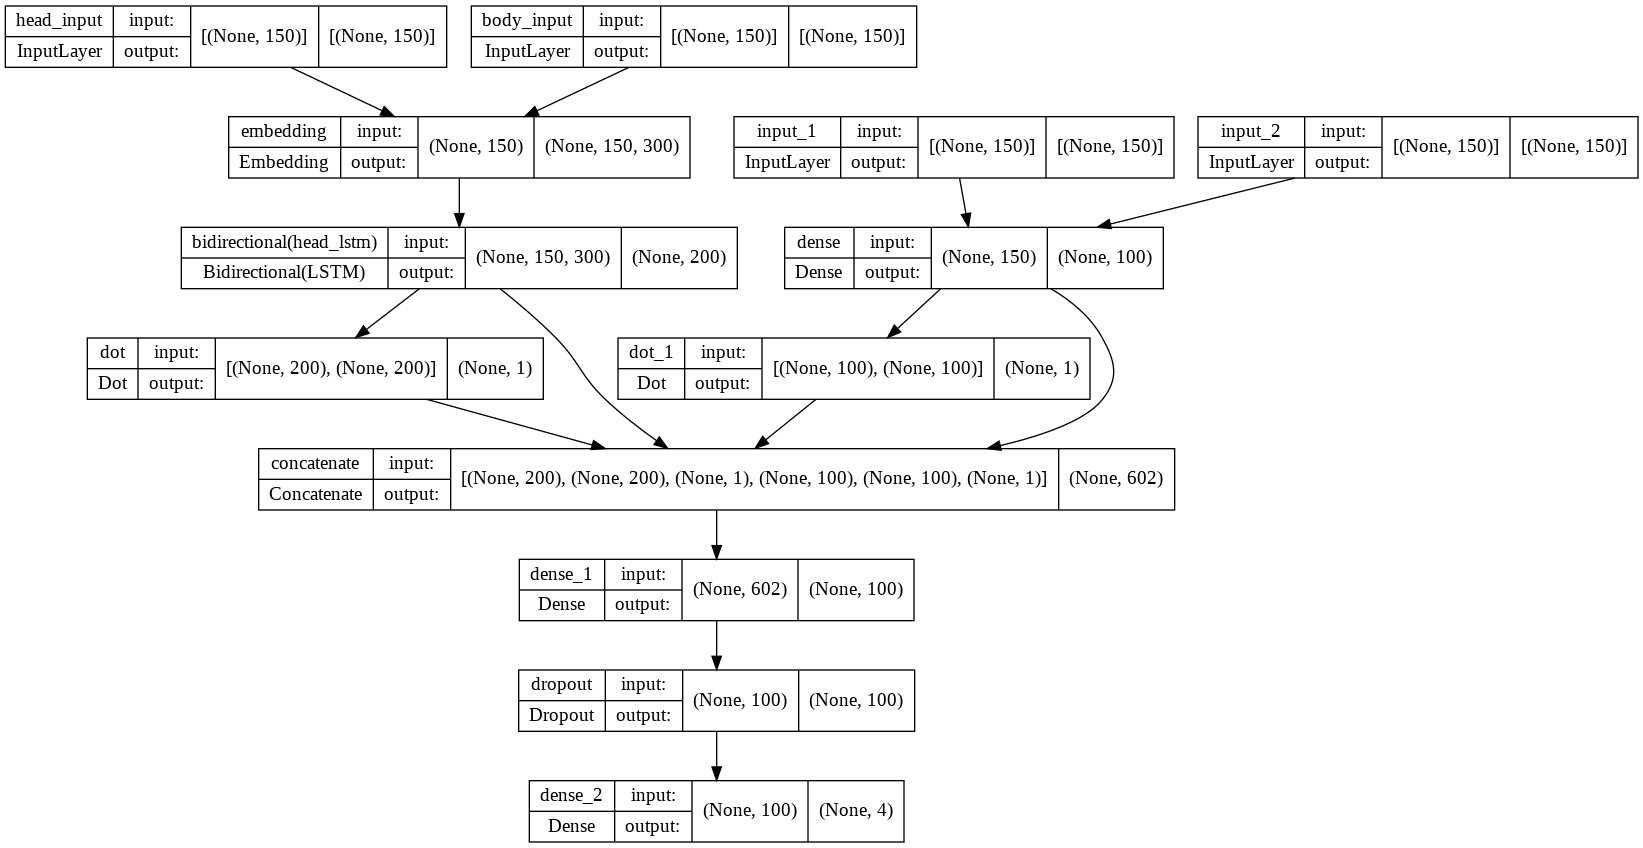

In [26]:
#Model creation

with tf.device('/device:GPU:0'):
    head_input = Input(shape=(MAX_SENT_LEN,), dtype='int32', name='head_input')
    body_input = Input(shape=(MAX_SENT_LEN,), dtype='int32', name='body_input')

    shared_embed = Embedding(len(tokenizer.word_index) + 1,EMBEDDING_DIM,weights=[embeddings_matrix_w2v],trainable=False)

    head_embed = shared_embed(head_input)
    body_embed = shared_embed(body_input)

    shared_lstm = Bidirectional(LSTM(100,dropout=0.2, recurrent_dropout=0.2, name='head_lstm'))

    head_lstm = shared_lstm(head_embed)
    body_lstm = shared_lstm(body_embed)

    dot_layer = dot([head_lstm,body_lstm],axes = 1, normalize=True)

    head_input_tfidf = Input(shape=(150,))
    body_input_tfidf = Input(shape=(150,))

    tf_dense = Dense(100,activation='relu')
    tf_dense_head = tf_dense(head_input_tfidf)
    tf_dense_body = tf_dense(body_input_tfidf)

    dot_layer_tfidf = dot([tf_dense_head,tf_dense_body],axes = 1, normalize=True)

    conc = concatenate([head_lstm,body_lstm,dot_layer,tf_dense_head,tf_dense_body,dot_layer_tfidf])

    dense = Dense(100,activation='relu')(conc)
    dense = Dropout(0.3)(dense)
    dense = Dense(4,activation='softmax')(dense)
    model = Model(inputs=[head_input,body_input,head_input_tfidf,body_input_tfidf], outputs=[dense])
    opt= Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'],experimental_run_tf_function = False)

    plot_model(model, to_file='model_final.png',show_shapes=True)

    from IPython.display import Image
    Image(retina=True, filename='model_final.png')

In [27]:
#Fit model while saving checkpoints and best accuracy to hdf5 file

with tf.device('/device:GPU:0'):
  filepath="/content/drive/MyDrive/FNC/best_epoch.hdf5"
  checkpoint = callbacks.ModelCheckpoint(filepath,monitor='val_accuracy', verbose=1,mode='max',save_best_only=True)

  callbacks_list1 = [checkpoint]

  runs = model.fit([X_train_head,X_train_body,X_train_head_tfidf,X_train_body_tfidf],[y_train],epochs=20, validation_data=([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf],[y_test]), batch_size=64,verbose = True,callbacks = callbacks_list1)

Train on 49972 samples, validate on 25413 samples
Epoch 1/20
49972/49972 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.8230

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.76638, saving model to /content/drive/MyDrive/FNC/fraud_1750.hdf5
49972/49972 [==============================] - 860s 17ms/sample - loss: 0.4920 - accuracy: 0.8230 - val_loss: 0.6217 - val_accuracy: 0.7664
Epoch 2/20
49972/49972 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9305
Epoch 2: val_accuracy did not improve from 0.76638
49972/49972 [==============================] - 862s 17ms/sample - loss: 0.1876 - accuracy: 0.9305 - val_loss: 0.7865 - val_accuracy: 0.7576
Epoch 3/20
49972/49972 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9557
Epoch 3: val_accuracy improved from 0.76638 to 0.77653, saving model to /content/drive/MyDrive/FNC/fraud_1750.hdf5
49972/49972 [==============================] - 861s 17ms/sample - loss: 0.1194 - accuracy: 0.9557 - val_loss: 0.8026 - val_accuracy: 0.7765
Epoch 4/20
49972/49972 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9664
E

In [28]:
pred = model.predict([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf])

pred = np.argmax(pred,axis = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [29]:
#New generate feautures function that only outputs the stance for prediction

def generate_features_comp(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    return y
  

comp_dataset = DataSet("competition_test")
y_competition = generate_features_comp(comp_dataset.stances, comp_dataset, "competition")

Xs = dict()
ys = dict()

#Run on competition dataset
actual = [LABELS[int(a)] for a in y_competition]
predict_labels= [LABELS[int(a)] for a in pred]
print(actual)
print(predict_labels)

print("Scores on the test set")
report_score(actual,predict_labels)

Reading dataset
Total stances: 25413
Total bodies: 904
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'agree', 'disagree', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'discuss', 'unr

58.92500804634696

In [30]:
#Print classification report

print(classification_report(actual,predict_labels))

              precision    recall  f1-score   support

       agree       0.40      0.26      0.32      1903
    disagree       0.10      0.04      0.05       697
     discuss       0.58      0.37      0.45      4464
   unrelated       0.83      0.95      0.89     18349

    accuracy                           0.77     25413
   macro avg       0.48      0.40      0.43     25413
weighted avg       0.73      0.77      0.74     25413



In [31]:
#Predict using the best model from the hdf5 file

best_model = load_model("/content/drive/MyDrive/FNC/fraud_1750.hdf5")

pred = best_model.predict([X_test_head,X_test_body,X_test_head_tfidf,X_test_body_tfidf])
pred = np.argmax(pred,axis = 1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [32]:
#New generate feautures function that only outputs the stance for prediction

def generate_features_comp(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    return y
  

comp_dataset = DataSet("competition_test")
y_competition = generate_features_comp(comp_dataset.stances, comp_dataset, "competition")

Xs = dict()
ys = dict()

#Run on competition dataset
actual = [LABELS[int(a)] for a in y_competition]
predict_labels= [LABELS[int(a)] for a in pred]
print(actual)
print(predict_labels)

print("Scores on the test set")
report_score(actual,predict_labels)

Reading dataset
Total stances: 25413
Total bodies: 904
['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'agree', 'disagree', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'discuss', 'unr

58.41218753352645

In [33]:
#Print classification report

print(classification_report(actual,predict_1))

              precision    recall  f1-score   support

       agree       0.43      0.25      0.32      1903
    disagree       0.10      0.03      0.05       697
     discuss       0.64      0.36      0.46      4464
   unrelated       0.82      0.97      0.89     18349

    accuracy                           0.78     25413
   macro avg       0.50      0.40      0.43     25413
weighted avg       0.74      0.78      0.75     25413



In [34]:
results_df = pd.read_csv ('/content/drive/MyDrive/FNC/data/competition_test_stances.csv')
del results_df["Stance"]
results_df["Stance"] = predict_labels
results_df.to_csv("/content/drive/MyDrive/FNC/results/answers.csv",index=False,header=True,encoding='utf-8')
